## Logistic VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Bernoulli base distribution with Logit Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

We run each scenario 5 times and compare the fit with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM, CSV
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept
m  = 1    # number of variance components
# true parameter values
βtrue = ones(p)
Σtrue = [0.5]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; Σtrue] #hold true parameters

#simulation parameters
samplesizes = [1000; 10000; 25000; 50000]
ns = [5; 10; 20; 50]
nsims = 50

50

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
ΣMseresult = vec(readdlm("mse_Sigma_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


800-element Vector{Float64}:
  0.209199181
  0.241330527
  0.206825168
  0.162843014
  0.225684586
  0.126941805
  0.265264912
  0.134587271
  0.148186739
  0.166350973
  0.147992203
  0.244628063
  0.191375835
  ⋮
 36.54791437
 34.93953137
 34.73785041
 31.79585046
 35.02894556
 33.21117271
 35.34497205
 32.63801611
 31.1774053
 33.82200997
 37.96880072
 31.76612365

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

800-element Vector{Float64}:
   0.772834131
   0.398304822
   0.311040933
   0.354611448
   0.331160966
   0.330916639
   0.319972768
   0.325546633
   0.323622606
   0.377054554
   0.384352347
   0.333680857
   0.322380243
   ⋮
 126.9693617
 142.3313853
 139.4169805
 141.5985778
 144.6314296
 147.2482658
 134.2226569
 146.8509694
 144.664723
 136.990111
 142.3278566
 121.9115808

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,5,0.21814,0.0158489,5000,0.202291,0.233989,4.3628e-5
2,1000,10,0.263779,0.00858441,10000,0.255195,0.272363,2.63779e-5
3,1000,20,0.338311,0.00922801,20000,0.329083,0.347539,1.69156e-5
4,1000,50,0.739631,0.00951503,50000,0.730116,0.749146,1.47926e-5
5,10000,5,1.1869,0.0294147,50000,1.15748,1.21631,2.37379e-5
6,10000,10,2.16213,0.0406131,100000,2.12152,2.20274,2.16213e-5
7,10000,20,3.07712,0.0437677,200000,3.03335,3.12088,1.53856e-5
8,10000,50,7.31272,0.0494192,500000,7.26331,7.36214,1.46254e-5
9,25000,5,3.00605,0.0563778,125000,2.94967,3.06242,2.40484e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,5,0.348069,0.00966854,5000,0.3384,0.357737,6.96137e-5
2,1000,10,0.5796,0.00617396,10000,0.573426,0.585774,5.796e-5
3,1000,20,1.10247,0.0127326,20000,1.08974,1.1152,5.51235e-5
4,1000,50,2.85953,0.0292138,50000,2.83032,2.88874,5.71906e-5
5,10000,5,3.03884,0.0308382,50000,3.008,3.06968,6.07768e-5
6,10000,10,5.5217,0.0548725,100000,5.46682,5.57657,5.5217e-5
7,10000,20,11.0203,0.100002,200000,10.9203,11.1203,5.51013e-5
8,10000,50,27.5793,0.248021,500000,27.3313,27.8274,5.51587e-5
9,25000,5,7.95686,0.0872029,125000,7.86966,8.04406,6.36549e-5


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


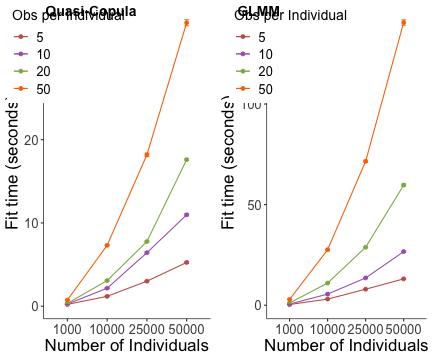

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('5', '10', '20', '50'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('1000', '10000', '25000', '50000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('5', '10', '20', '50'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('1000', '10000', '25000', '50000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [9]:
using RCall
R"""
ggsave('fittime_nsamples_logistic_vs_glmm.png', fittime_nsamples, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nsamples_logistic_vs_glmm.png"


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


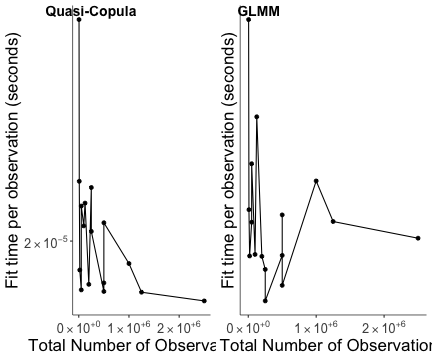

RObject{VecSxp}


In [10]:
using RCall
@rput timedf1
@rput timedf2

R"""
library(scales)
library(ggplot2)
timedf1$obssize <- factor(timedf1$obssize, levels = c('5', '10', '20', '50'))
timedf1$samplesize <- factor(timedf1$samplesize, levels = c('1000', '10000', '25000', '50000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs1 = ggplot(timedf1, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(2 * 10^-5, 10^-4, 2 * 10^-4, 3 * 10^-4, 4 * 10^-4, 5 * 10^-4, 6 * 10^-4), labels= fancy_scientific)

# glmm fit times
timedf2$obssize <- factor(timedf2$obssize, levels = c('5', '10', '20', '50'))
timedf2$samplesize <- factor(timedf2$samplesize, levels = c('1000', '10000', '25000', '50000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs2 = ggplot(timedf2, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(2 * 10^-5, 10^-4, 2 * 10^-4, 3 * 10^-4, 4 * 10^-4, 5 * 10^-4, 6 * 10^-4), labels= fancy_scientific)

fittime_perobs = plot_grid(fittimeperobs1, fittimeperobs2, labels = c("Quasi-Copula", "GLMM"))

"""

In [11]:
R"""
ggsave('fittime_perobs_logistic_vs_glmm.png', fittime_perobs, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_perobs_logistic_vs_glmm.png"


In [ ]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βΣcoverage = readdlm("beta_sigma_coverage_multivariate_logistic_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βΣcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


In [ ]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresultpoisson = vec(readdlm("mse_beta_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson = vec(readdlm("mse_Sigma_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

βMseresultpoisson_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresultpoisson, Σmse = ΣMseresultpoisson, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresultpoisson_GLMM, Σmse = ΣMseresultpoisson_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :Sigmamse]; msedf2[!, :betamse]; msedf2[!, :Sigmamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Logistic Quasi-Copula"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Logistic GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

In [ ]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^1]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('5', '10', '20', '50'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('1000', '10000', '25000', '50000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'Sigma'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(Sigma))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Logistic Quasi-Copula', 'Logistic GLMM'),
    labels = c(expression(paste("Logistic Quasi-Copula")), expression(paste("Logistic GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [ ]:
R"""
ggsave('updated_msefacetplot_logistic.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""